In [1]:
import gpytorch
import os
import random
import torch
import tqdm
import time
import matplotlib
import math
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import itertools
import argparse

from sparsemax import Sparsemax
from scipy.stats import ttest_ind
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from src.models import AE
from src.opt import ol_partition_dkbo, pure_dkbo, ol_filter_dkbo
# from src.utils import 

# parse the cli
class tmp():
    def __init__(self) -> None:
        pass
cli_args = tmp()
cli_args.name = "filtering_1deg"
cli_args.aedir = "./tmp/1deg_ae"
cli_args.subdir="./res/intersec/visual"  
cli_args.datadir="./data/opt_eg1d.npy" 
cli_args.run_times=1 
cli_args.acq_func="ucb"
cli_args.learning_rate=4  
cli_args.intersection=False  
cli_args.a=False
cli_args.r=False
cli_args.n=False
cli_args.high_dim=False
cli_args.init_num=10
cli_args.o=True 
cli_args.p=True 
cli_args.s=True 
cli_args.f=True 
cli_args.return_model=True 
cli_args.v=True

### load dataset
assert not (cli_args.datadir is None)
if cli_args.datadir.endswith(".pt"):
    dataset = torch.load(cli_args.datadir)  # want to find the maximal
elif cli_args.datadir.endswith(".npy"):
    dataset = torch.from_numpy(np.load(cli_args.datadir))
data_dim = dataset.shape[1]-1
# dataset = torch.load(cli_args.datadir)  # want to find the maximal
# data_dim = dataset.shape[1]-1

# original Objective
ROBUST = True
ScalerClass = RobustScaler if ROBUST else StandardScaler
scaler = ScalerClass().fit(dataset[:,:-1])                   # obj foldx -> rosetta
scaled_f_data = scaler.transform(dataset[:,:-1])
scaled_input_tensor = torch.from_numpy(scaled_f_data).float()
output_tensor = dataset[:,-1].float()
shuffle_filter = np.random.choice(scaled_f_data.shape[0], scaled_f_data.shape[0], replace=False)
train_output = -1 * output_tensor.reshape([-1,1]).float() if cli_args.n else output_tensor.reshape([-1,1]).float()

# dkbo experiment
verbose = cli_args.v
fix_seed = cli_args.f

low_dim = not cli_args.high_dim
pretrained = not (cli_args.aedir is None)

# pretrain AE
if not (cli_args.aedir is None) and cli_args.a:
    ae = AE(scaled_input_tensor, lr=1e-3)
    # print(scaled_input_tensor.shape)
    ae.train_ae(epochs=10, batch_size=200, verbose=True)
    torch.save(ae.state_dict(), cli_args.aedir)
    if cli_args.v:
        print(f"pretrained ae stored in {cli_args.aedir}")


# Exp1

Learning rate 0.0001 Filtering True fix_seed True beta 2.0 Regularize False Low dim True CI intersection False verbose=True


100%|██████████| 100/100 [00:02<00:00, 38.75it/s, loss=1.1]





























































































































100%|██████████| 100/100 [00:03<00:00, 31.76it/s, loss=1.24]




























































































































Experiment Rep: 100%|██████████| 1/1 [00:33<00:00, 33.64s/it]


File stored to ./res/intersec/visual/OL-filtering_1deg-2.0-none-ucb-R1-P2-T10_I5_L4-TI100-USexact


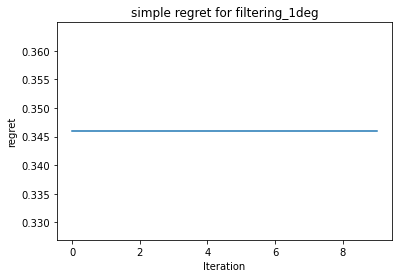

In [3]:
cli_args.beta=2.0 
cli_args.filter_interval=5
cli_args.opt_horizon=10
cli_args.train_times=100 
cli_args.learning_rate=4 
lr_rank = -cli_args.learning_rate
learning_rate = 10 ** lr_rank

print(f"Learning rate {learning_rate} Filtering {cli_args.o} fix_seed {fix_seed} beta {cli_args.beta} Regularize {cli_args.r} Low dim {low_dim} CI intersection {cli_args.intersection} verbose={verbose}")
if cli_args.o:
    res = ol_filter_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output, n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim, beta=cli_args.beta, regularize=cli_args.r,   ci_intersection=cli_args.intersection,
                    n_iter=cli_args.opt_horizon, filter_interval=cli_args.filter_interval, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_times=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=not cli_args.return_model, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir)
else:
    pure_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output,  n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim,
                    n_iter=cli_args.opt_horizon, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_iter=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=True, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir,)


## Plot func

torch.Size([1000]) torch.Size([1000])
Threshold -0.18415546417236328 -1.897552251815796
tensor([ 0.2465, -0.2015, -0.2438, -0.2142,  0.2531,  0.1198,  0.2613,  0.1949,
        -0.2429, -0.2142, -0.2382, -0.2456, -0.2404, -0.1733, -0.0734])


/opt/homebrew/Caskroom/miniforge/base/envs/DS/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


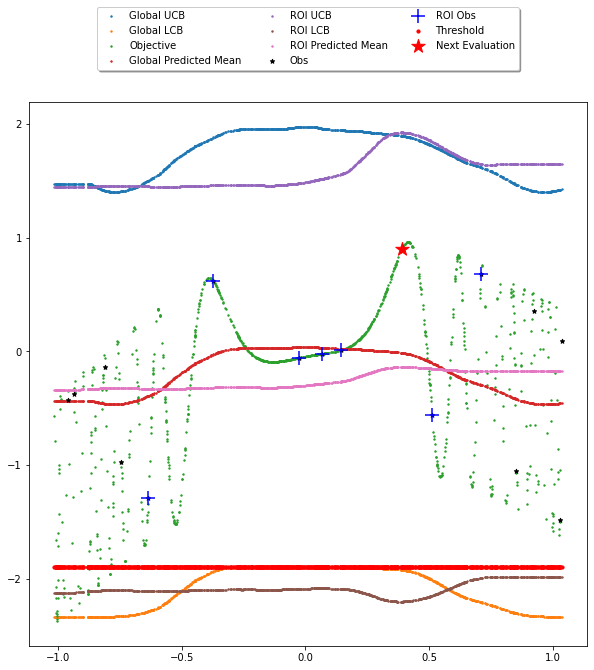

In [126]:
def scale(beta, lower, upper):
        beta = beta/2
        _roi_ucb_scaled = (upper - lower) / 2 * (beta-1) + upper
        _roi_lcb_scaled = (upper - lower) / 2 * (1-beta) + lower
        return _roi_lcb_scaled, _roi_ucb_scaled

def plot_result(res, beta, plot_beta=2):
        dk, sim_dk_ae = res
        _dk_lower, _dk_upper = dk.CI(scaled_input_tensor)
        dk_lower, dk_upper = scale(plot_beta, _dk_lower, _dk_upper)
        dk_mean = (dk_upper + dk_lower)/2
        _roi_lower, _roi_upper = sim_dk_ae.dkl.CI(scaled_input_tensor)
        roi_lower, roi_upper = scale(plot_beta, _roi_lower, _roi_upper)
        roi_mean = (roi_upper + roi_lower )/2
        print(scaled_input_tensor[:,0].shape, torch.unique(scaled_input_tensor[:,0]).shape)
        plt.figure(figsize=[10,10])
        plt.scatter(scaled_input_tensor[:,0], dk_upper, s=2, label="Global UCB")
        plt.scatter(scaled_input_tensor[:,0], dk_lower,  s=2,label="Global LCB")
        plt.scatter(scaled_input_tensor[:,0], train_output, s=2, label="Objective")
        plt.scatter(scaled_input_tensor[:,0], dk_mean, s=2, label="Global Predicted Mean")
        plt.scatter(scaled_input_tensor[:,0], roi_upper,  s=2, label="ROI UCB")
        plt.scatter(scaled_input_tensor[:,0], roi_lower,  s=2, label="ROI LCB")
        plt.scatter(scaled_input_tensor[:,0], roi_mean, s=2, label="ROI Predicted Mean")

        plt.scatter(dk.train_x[:,0], dk.train_y, s=20, marker='*', color='black', label="Obs")
        global_lcb, global_ucb = scale(beta, _dk_lower, _dk_upper)
        _obs_lcb, _obs_ucb = dk.CI(dk.train_x)
        obs_lcb, obs_ucb = scale(beta, _obs_lcb, _obs_ucb)
        threshold = global_lcb.max()
        ucb_filter = obs_ucb >= threshold
        print(f"Threshold {threshold} {dk_lower.max()}")
        print(obs_ucb)

        # plt.scatter(sim_dk_ae.dkl.train_x[:,0], sim_dk_ae.dkl.train_y, s=200, marker='+', color='blue', label="ROI Obs")
        plt.scatter(dk.train_x[ucb_filter,0], dk.train_y[ucb_filter], s=200, marker='+', color='blue', label="ROI Obs")
        plt.scatter(scaled_input_tensor[:,0], torch.ones(scaled_input_tensor[:,0].size()) * dk_lower.max().numpy(), s=10, color="red", label="Threshold")
        next_pick = torch.argmax(roi_upper)
        plt.scatter(scaled_input_tensor[next_pick,0], train_output[next_pick], s=200, marker='*', color='red', label="Next Evaluation")
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
        
        # plt.show()
        plt.savefig(f"1DEG-lr{learning_rate}-beta{cli_args.beta}-train{cli_args.train_times}.png")
  
# plot_result(res)
plot_result(res5, 0.23, 2)

torch.Size([1000]) torch.Size([1000])
Threshold -0.18415546417236328 -0.18415546417236328
tensor([ 0.2465, -0.2015, -0.2438, -0.2142,  0.2531,  0.1198,  0.2613,  0.1949,
        -0.2429, -0.2142, -0.2382, -0.2456, -0.2404, -0.1733, -0.0734])


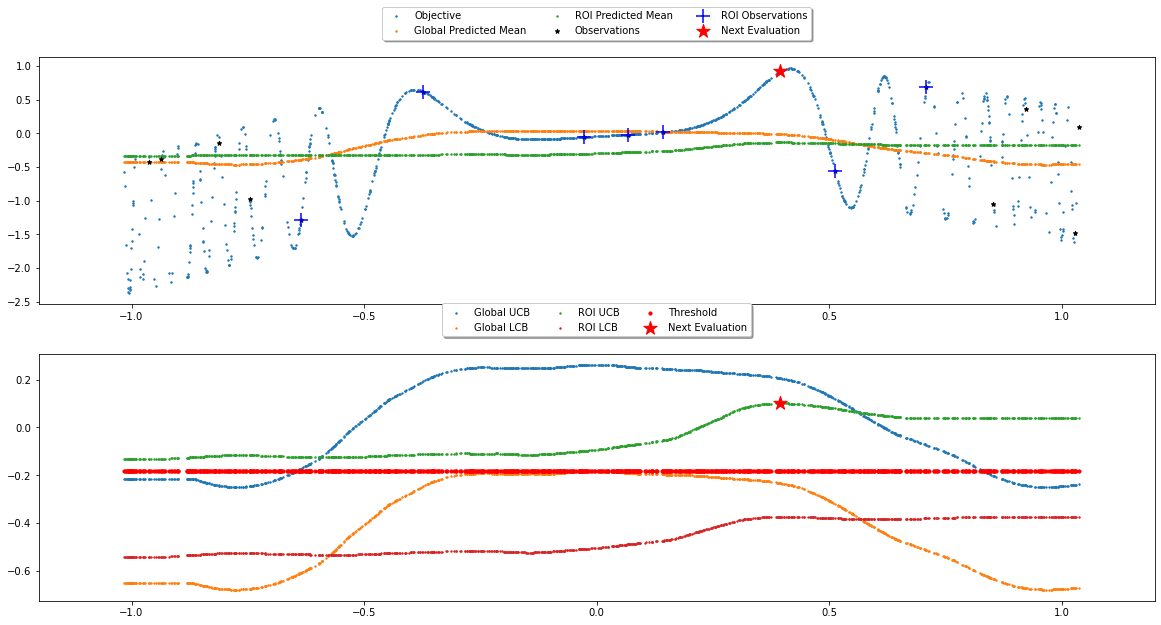

In [127]:
def plot_result(res, beta, plot_beta=2):
        dk, sim_dk_ae = res
        _dk_lower, _dk_upper = dk.CI(scaled_input_tensor)
        dk_lower, dk_upper = scale(plot_beta, _dk_lower, _dk_upper)
        dk_mean = (dk_upper + dk_lower)/2
        _roi_lower, _roi_upper = sim_dk_ae.dkl.CI(scaled_input_tensor)
        roi_lower, roi_upper = scale(plot_beta, _roi_lower, _roi_upper)
        roi_mean = (roi_upper + roi_lower )/2
        print(scaled_input_tensor[:,0].shape, torch.unique(scaled_input_tensor[:,0]).shape)
        plt.figure(figsize=[20,10])
        ax1 = plt.subplot(2,1,1)
        ax2 = plt.subplot(2,1,2)
        ax2.scatter(scaled_input_tensor[:,0], dk_upper, s=2, label="Global UCB")
        ax2.scatter(scaled_input_tensor[:,0], dk_lower,  s=2,label="Global LCB")
        ax1.scatter(scaled_input_tensor[:,0], train_output, s=2, label="Objective")
        ax1.scatter(scaled_input_tensor[:,0], dk_mean, s=2, label="Global Predicted Mean")
        ax2.scatter(scaled_input_tensor[:,0], roi_upper,  s=2, label="ROI UCB")
        ax2.scatter(scaled_input_tensor[:,0], roi_lower,  s=2, label="ROI LCB")
        ax1.scatter(scaled_input_tensor[:,0], roi_mean, s=2, label="ROI Predicted Mean")

        ax1.scatter(dk.train_x[:,0], dk.train_y, s=20, marker='*', color='black', label="Observations")
        global_lcb, global_ucb = scale(beta, _dk_lower, _dk_upper)
        _obs_lcb, _obs_ucb = dk.CI(dk.train_x)
        obs_lcb, obs_ucb = scale(beta, _obs_lcb, _obs_ucb)
        threshold = global_lcb.max()
        ucb_filter = obs_ucb >= threshold
        print(f"Threshold {threshold} {dk_lower.max()}")
        print(obs_ucb)

        # plt.scatter(sim_dk_ae.dkl.train_x[:,0], sim_dk_ae.dkl.train_y, s=200, marker='+', color='blue', label="ROI Obs")
        ax1.scatter(dk.train_x[ucb_filter,0], dk.train_y[ucb_filter], s=200, marker='+', color='blue', label="ROI Observations")
        ax2.scatter(scaled_input_tensor[:,0], torch.ones(scaled_input_tensor[:,0].size()) * dk_lower.max().numpy(), s=10, color="red", label="Threshold")
        next_pick = torch.argmax(roi_upper)
        ax1.scatter(scaled_input_tensor[next_pick,0], train_output[next_pick], s=200, marker='*', color='red', label="Next Evaluation")
        ax2.scatter(scaled_input_tensor[next_pick,0], roi_upper[next_pick], s=200, marker='*', color='red', label="Next Evaluation")
        # handles, labels = ax1.get_legend_handles_labels()
        # legend1 = plt.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05),
        #   ncol=3, fancybox=True, shadow=True)
        # ax1.add_artist(legend1)
        ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True)
        #   ncol=3, fancybox=True, shadow=True)
        # handles, labels = ax2.get_legend_handles_labels()
        # legend2 = plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
        #   ncol=3, fancybox=True, shadow=True)
        # ax2.add_artist(legend2)
        # plt.show()
        ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True)
        ax2.set_xlim([-1.2, 1.2])
        ax1.set_xlim([-1.2, 1.2])
        plt.savefig(f"1DEG-lr{learning_rate}-beta{cli_args.beta}-train{cli_args.train_times}.png")
  
# plot_result(res)
plot_result(res5, 0.23, 0.23)

/opt/homebrew/Caskroom/miniforge/base/envs/DS/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Threshold -0.18415546417236328 -0.18415546417236328
tensor([ 0.2465, -0.2015, -0.2438, -0.2142,  0.2531,  0.1198,  0.2613,  0.1949,
        -0.2429, -0.2142, -0.2382, -0.2456, -0.2404, -0.1733, -0.0734])


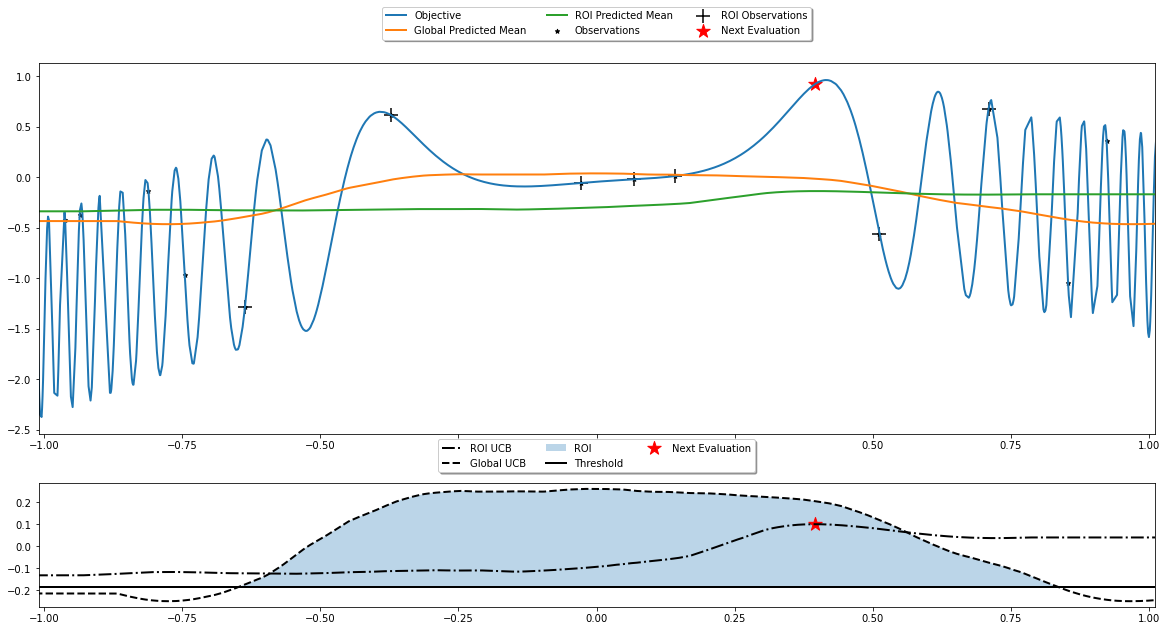

In [188]:
def plot_result_cont(res, beta, plot_beta=2):
        """
        Beta: acting beta for filtering.
        Plot_beta: merely for visualization.
        """
        dk, sim_dk_ae = res
        _dk_lower, _dk_upper = dk.CI(scaled_input_tensor)
        dk_lower, dk_upper = scale(plot_beta, _dk_lower, _dk_upper)
        dk_mean = (dk_upper + dk_lower)/2
        _roi_lower, _roi_upper = sim_dk_ae.dkl.CI(scaled_input_tensor)
        roi_lower, roi_upper = scale(plot_beta, _roi_lower, _roi_upper)
        roi_mean = (roi_upper + roi_lower )/2
        # print(scaled_input_tensor[:,0].shape, torch.unique(scaled_input_tensor[:,0]).shape)
        global_order = torch.argsort(scaled_input_tensor[:,0])
        # plt.figure(figsize=[20,10])
        # ax1 = plt.subplot(2,1,1)
        # ax2 = plt.subplot(2,1,2)
        _, (ax1, ax2) = plt.subplots(2, 1, figsize=[20,10], gridspec_kw={'height_ratios': [3, 1]})
        # ax1_beta = 0.8 * plot_beta
        ax1_beta = 1
        ax2_beta = 1
        # ax2_beta = 1 / plot_beta


        ax1.plot(scaled_input_tensor[global_order,0], train_output[global_order] * ax1_beta, linewidth=2, label="Objective")
        ax1.plot(scaled_input_tensor[global_order,0], dk_mean[global_order] * ax1_beta,    linewidth=2, label="Global Predicted Mean")
        ax1.plot(scaled_input_tensor[global_order,0], roi_mean[global_order]* ax1_beta,   linewidth=2, label="ROI Predicted Mean")
        ax2.plot(scaled_input_tensor[global_order,0], roi_upper[global_order] * ax2_beta,  linewidth=2, linestyle='-.', color="black", label="ROI UCB")
        # ax2.plot(scaled_input_tensor[global_order,0], roi_lower[global_order],  linewidth=2, label="ROI LCB")
        ax2.plot(scaled_input_tensor[global_order,0], dk_upper[global_order] * ax2_beta,   linewidth=2, linestyle='--', color="black", label="Global UCB")
        # ax2.plot(scaled_input_tensor[global_order,0], dk_lower[global_order],   linewidth=2, label="Global LCB")
        # ax2.fill_between(scaled_input_tensor[global_order,0], roi_lower[global_order], roi_upper[global_order], alpha=0.3, label="ROI CI")
        # ax2.fill_between(scaled_input_tensor[global_order,0], dk_lower[global_order], dk_upper[global_order], alpha=0.3, label="Global CI")
        _threshold = torch.ones(scaled_input_tensor[:,0].size()) * (dk_lower.max()) 
        ax2.fill_between(scaled_input_tensor[global_order,0], _threshold * ax2_beta, dk_upper[global_order] * ax2_beta, where=dk_upper[global_order] > dk_lower.max(), alpha=0.3, label="ROI")
        ax2.plot(scaled_input_tensor[global_order,0], _threshold * ax2_beta, color="black", linewidth=2, label="Threshold")
        

        ax1.scatter(dk.train_x[:,0], dk.train_y * ax1_beta, s=20, marker='*', color='black', label="Observations")
        global_lcb, global_ucb = scale(beta, _dk_lower, _dk_upper)
        _obs_lcb, _obs_ucb = dk.CI(dk.train_x)
        obs_lcb, obs_ucb = scale(beta, _obs_lcb, _obs_ucb)
        threshold = global_lcb.max()
        ucb_filter = obs_ucb >= threshold
        print(f"Threshold {threshold} {dk_lower.max()}")
        print(obs_ucb)

        ax1.scatter(dk.train_x[ucb_filter,0], dk.train_y[ucb_filter] * ax1_beta, s=200, marker='+', color='black', label="ROI Observations")
        next_pick = torch.argmax(roi_upper)
        ax1.scatter(scaled_input_tensor[next_pick,0], train_output[next_pick] * ax1_beta, s=200, marker='*', color='red', label="Next Evaluation")
        ax2.scatter(scaled_input_tensor[next_pick,0], roi_upper[next_pick]* ax2_beta, s=200, marker='*', color='red', label="Next Evaluation")

        ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True)

        ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True)
        ax2.set_xlim([-1.01, 1.01])
        ax1.set_xlim([-1.01, 1.01])
        # ax1.get_yaxis().set_visible(False)
        # ax2.get_yaxis().set_visible(False)
        plt.savefig(f"1DEG-lr{learning_rate}-beta{cli_args.beta}-train{cli_args.train_times}.eps", format='eps')
  
# plot_result(res)
plot_result_cont(res5, 0.23, 0.23)

/opt/homebrew/Caskroom/miniforge/base/envs/DS/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Threshold -0.18415546417236328 -0.18415546417236328
tensor([ 0.2465, -0.2015, -0.2438, -0.2142,  0.2531,  0.1198,  0.2613,  0.1949,
        -0.2429, -0.2142, -0.2382, -0.2456, -0.2404, -0.1733, -0.0734])


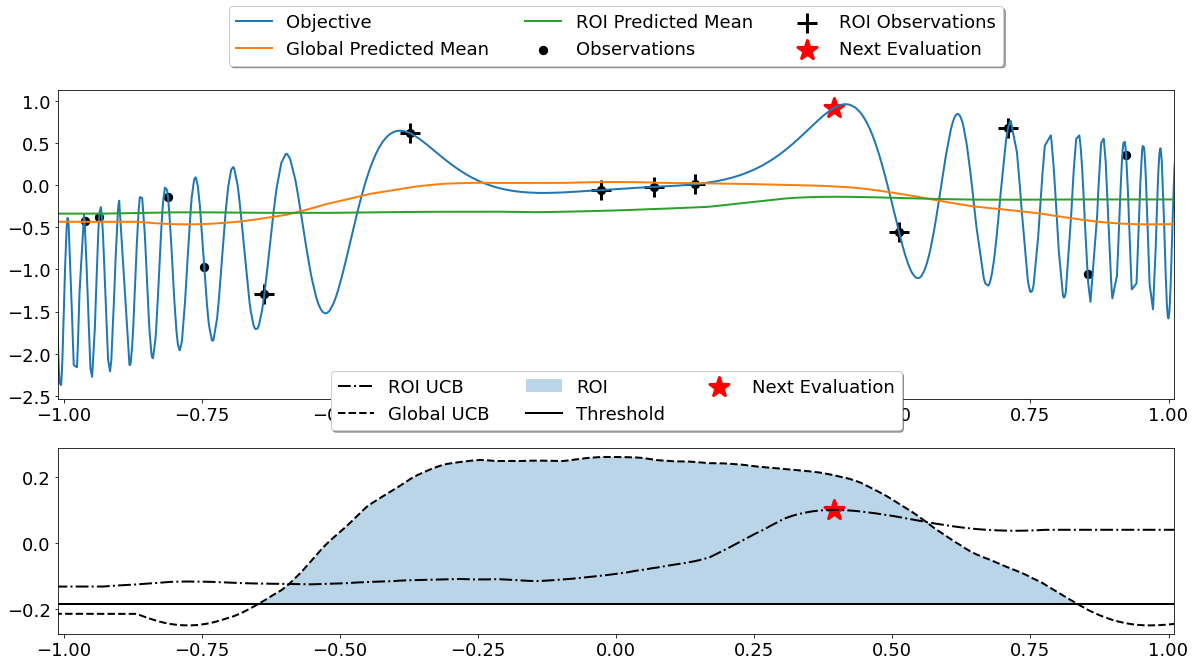

In [229]:
def plot_result_cont_large(res, beta, plot_beta=2) :
        """
        Beta: acting beta for filtering.
        Plot_beta: merely for visualization.
        """
        font_size = 18
        marker_width = 3
        marker_size = 400

        dk, sim_dk_ae = res
        _dk_lower, _dk_upper = dk.CI(scaled_input_tensor)
        dk_lower, dk_upper = scale(plot_beta, _dk_lower, _dk_upper)
        dk_mean = (dk_upper + dk_lower)/2
        _roi_lower, _roi_upper = sim_dk_ae.dkl.CI(scaled_input_tensor)
        roi_lower, roi_upper = scale(plot_beta, _roi_lower, _roi_upper)
        roi_mean = (roi_upper + roi_lower )/2
        # print(scaled_input_tensor[:,0].shape, torch.unique(scaled_input_tensor[:,0]).shape)
        global_order = torch.argsort(scaled_input_tensor[:,0])
        # plt.figure(figsize=[20,10])
        # ax1 = plt.subplot(2,1,1)
        # ax2 = plt.subplot(2,1,2)
        _, (ax1, ax2) = plt.subplots(2, 1, figsize=[20,10], gridspec_kw={'height_ratios': [2.5, 1.5]})
        # ax1_beta = 0.8 * plot_beta
        ax1_beta = 1
        ax2_beta = 1
        # ax2_beta = 1 / plot_beta


        ax1.plot(scaled_input_tensor[global_order,0], train_output[global_order] * ax1_beta, linewidth=2, label="Objective")
        ax1.plot(scaled_input_tensor[global_order,0], dk_mean[global_order] * ax1_beta,    linewidth=2, label="Global Predicted Mean")
        ax1.plot(scaled_input_tensor[global_order,0], roi_mean[global_order]* ax1_beta,   linewidth=2, label="ROI Predicted Mean")
        ax2.plot(scaled_input_tensor[global_order,0], roi_upper[global_order] * ax2_beta,  linewidth=2, linestyle='-.', color="black", label="ROI UCB")
        # ax2.plot(scaled_input_tensor[global_order,0], roi_lower[global_order],  linewidth=2, label="ROI LCB")
        ax2.plot(scaled_input_tensor[global_order,0], dk_upper[global_order] * ax2_beta,   linewidth=2, linestyle='--', color="black", label="Global UCB")
        # ax2.plot(scaled_input_tensor[global_order,0], dk_lower[global_order],   linewidth=2, label="Global LCB")
        # ax2.fill_between(scaled_input_tensor[global_order,0], roi_lower[global_order], roi_upper[global_order], alpha=0.3, label="ROI CI")
        # ax2.fill_between(scaled_input_tensor[global_order,0], dk_lower[global_order], dk_upper[global_order], alpha=0.3, label="Global CI")
        _threshold = torch.ones(scaled_input_tensor[:,0].size()) * (dk_lower.max()) 
        ax2.fill_between(scaled_input_tensor[global_order,0], _threshold * ax2_beta, dk_upper[global_order] * ax2_beta, where=dk_upper[global_order] > dk_lower.max(), alpha=0.3, label="ROI")
        ax2.plot(scaled_input_tensor[global_order,0], _threshold * ax2_beta, color="black", linewidth=2, label="Threshold")
        

        ax1.scatter(dk.train_x[:,0], dk.train_y * ax1_beta, s=marker_size/10, marker='o', linewidths=marker_width, color='black', label="Observations")
        global_lcb, global_ucb = scale(beta, _dk_lower, _dk_upper)
        _obs_lcb, _obs_ucb = dk.CI(dk.train_x)
        obs_lcb, obs_ucb = scale(beta, _obs_lcb, _obs_ucb)
        threshold = global_lcb.max()
        ucb_filter = obs_ucb >= threshold
        print(f"Threshold {threshold} {dk_lower.max()}")
        print(obs_ucb)

        ax1.scatter(dk.train_x[ucb_filter,0], dk.train_y[ucb_filter] * ax1_beta, s=marker_size, marker='+', linewidths=marker_width, color='black', label="ROI Observations")
        next_pick = torch.argmax(roi_upper)
        ax1.scatter(scaled_input_tensor[next_pick,0], train_output[next_pick] * ax1_beta, s=marker_size, marker='*', linewidths=marker_width, color='red', label="Next Evaluation")
        ax2.scatter(scaled_input_tensor[next_pick,0], roi_upper[next_pick]* ax2_beta, s=marker_size, marker='*', linewidths=marker_width, color='red', label="Next Evaluation")

        ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True, prop={'size': font_size})

        ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True, prop={'size': font_size})
        ax2.tick_params(axis='both', which='major', labelsize=font_size)
        ax1.tick_params(axis='both', which='major', labelsize=font_size)
        ax2.set_xlim([-1.01, 1.01])
        ax1.set_xlim([-1.01, 1.01])
        # ax1.get_yaxis().set_visible(False)
        # ax2.get_yaxis().set_visible(False)
        plt.savefig(f"1DEG-lr{learning_rate}-beta{cli_args.beta}-train{cli_args.train_times}.eps", format='eps')
  
# plot_result(res)
plot_result_cont_large(res5, 0.23, 0.23)

/opt/homebrew/Caskroom/miniforge/base/envs/DS/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Threshold -0.18415546417236328 -0.18415546417236328
tensor([ 0.2465, -0.2015, -0.2438, -0.2142,  0.2531,  0.1198,  0.2613,  0.1949,
        -0.2429, -0.2142, -0.2382, -0.2456, -0.2404, -0.1733, -0.0734])


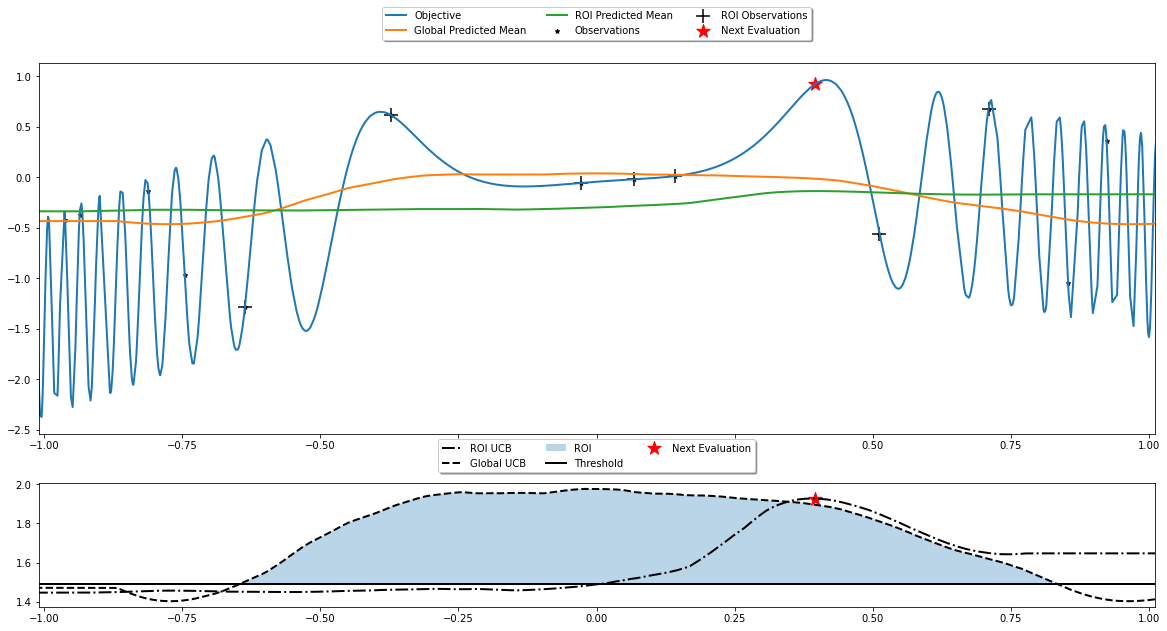

In [226]:
def plot_result_cont_2(res, beta, plot_beta=2):
        """
        Beta: acting beta for filtering.
        Plot_beta: merely for visualization.
        """
        dk, sim_dk_ae = res
        _dk_lower, _dk_upper = dk.CI(scaled_input_tensor)
        dk_lower, dk_upper = scale(plot_beta, _dk_lower, _dk_upper)
        dk_mean = (dk_upper + dk_lower)/2
        _roi_lower, _roi_upper = sim_dk_ae.dkl.CI(scaled_input_tensor)
        roi_lower, roi_upper = scale(plot_beta, _roi_lower, _roi_upper)
        roi_mean = (roi_upper + roi_lower )/2
        # print(scaled_input_tensor[:,0].shape, torch.unique(scaled_input_tensor[:,0]).shape)
        global_order = torch.argsort(scaled_input_tensor[:,0])
        # plt.figure(figsize=[20,10])
        # ax1 = plt.subplot(2,1,1)
        # ax2 = plt.subplot(2,1,2)
        _, (ax1, ax2) = plt.subplots(2, 1, figsize=[20,10], gridspec_kw={'height_ratios': [3, 1]})
        # ax1_beta = 0.8 * plot_beta
        ax1_beta = 1
        ax2_beta = 1
        # ax2_beta = 1 / plot_beta


        ax1.plot(scaled_input_tensor[global_order,0], train_output[global_order] * ax1_beta, linewidth=2, label="Objective")
        _obj = np.vstack([scaled_input_tensor[global_order,0].numpy(), train_output[global_order].numpy().squeeze()])
        # print(_obj.shape)
        np.save('objective_1dillustration.npy', _obj )
        ax1.plot(scaled_input_tensor[global_order,0], dk_mean[global_order] * ax1_beta,    linewidth=2, label="Global Predicted Mean")
        ax1.plot(scaled_input_tensor[global_order,0], roi_mean[global_order]* ax1_beta,   linewidth=2, label="ROI Predicted Mean")
        ax2.plot(scaled_input_tensor[global_order,0], _roi_upper[global_order] * ax2_beta,  linewidth=2, linestyle='-.', color="black", label="ROI UCB")
        _roi_ucb = np.vstack([scaled_input_tensor[global_order,0].numpy(), _roi_upper[global_order].numpy().squeeze()])
        np.save('roi_ucb_1dillustration.npy', _obj )
        # ax2.plot(scaled_input_tensor[global_order,0], roi_lower[global_order],  linewidth=2, label="ROI LCB")
        ax2.plot(scaled_input_tensor[global_order,0], _dk_upper[global_order] * ax2_beta,   linewidth=2, linestyle='--', color="black", label="Global UCB")
        _global_ucb = np.vstack([scaled_input_tensor[global_order,0].numpy(), _dk_upper[global_order].numpy().squeeze()])
        np.save('global_ucb_1dillustration.npy', _obj )
        # ax2.plot(scaled_input_tensor[global_order,0], dk_lower[global_order],   linewidth=2, label="Global LCB")
        # ax2.fill_between(scaled_input_tensor[global_order,0], roi_lower[global_order], roi_upper[global_order], alpha=0.3, label="ROI CI")
        # ax2.fill_between(scaled_input_tensor[global_order,0], dk_lower[global_order], dk_upper[global_order], alpha=0.3, label="Global CI")
        _threshold_idx = torch.abs(dk_upper - dk_lower.max()).argmin()
        _threshold_value = _dk_upper[_threshold_idx]
        _threshold = torch.ones(scaled_input_tensor[:,0].size()) * (_threshold_value) 
        ax2.fill_between(scaled_input_tensor[global_order,0], _threshold * ax2_beta, _dk_upper[global_order] * ax2_beta, where=dk_upper[global_order] > dk_lower.max(), alpha=0.3, label="ROI")
        ax2.plot(scaled_input_tensor[global_order,0], _threshold * ax2_beta, color="black", linewidth=2, label="Threshold")
        

        ax1.scatter(dk.train_x[:,0], dk.train_y * ax1_beta, s=20, marker='*', color='black', label="Observations")
        global_lcb, global_ucb = scale(beta, _dk_lower, _dk_upper)
        _obs_lcb, _obs_ucb = dk.CI(dk.train_x)
        obs_lcb, obs_ucb = scale(beta, _obs_lcb, _obs_ucb)
        threshold = global_lcb.max()
        ucb_filter = obs_ucb >= threshold
        print(f"Threshold {threshold} {dk_lower.max()}")
        print(obs_ucb)

        ax1.scatter(dk.train_x[ucb_filter,0], dk.train_y[ucb_filter] * ax1_beta, s=200, marker='+', color='black', label="ROI Observations")
        next_pick = torch.argmax(roi_upper)
        ax1.scatter(scaled_input_tensor[next_pick,0], train_output[next_pick] * ax1_beta, s=200, marker='*', color='red', label="Next Evaluation")
        ax2.scatter(scaled_input_tensor[next_pick,0], _roi_upper[next_pick]* ax2_beta, s=200, marker='*', color='red', label="Next Evaluation")

        ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True)

        ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True)
        ax2.set_xlim([-1.01, 1.01])
        ax1.set_xlim([-1.01, 1.01])
        # ax1.get_yaxis().set_visible(False)
        # ax2.get_yaxis().set_visible(False)
        plt.savefig(f"1DEG-lr{learning_rate}-beta{cli_args.beta}-train{cli_args.train_times}.eps", format='eps')
  
# plot_result(res)
plot_result_cont_2(res5, 0.23, 0.23)

/opt/homebrew/Caskroom/miniforge/base/envs/DS/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Threshold -0.18415546417236328 -0.18415546417236328
tensor([ 0.2465, -0.2015, -0.2438, -0.2142,  0.2531,  0.1198,  0.2613,  0.1949,
        -0.2429, -0.2142, -0.2382, -0.2456, -0.2404, -0.1733, -0.0734])


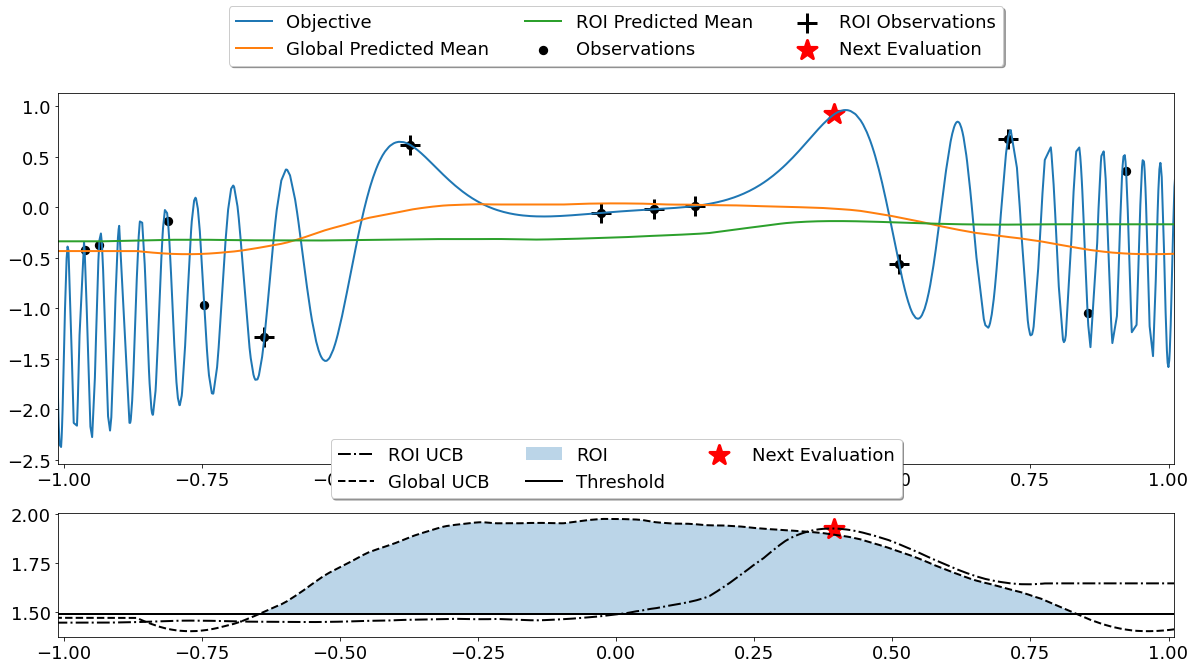

In [224]:
def plot_result_cont_3(res, beta, plot_beta=2):
        """
        Beta: acting beta for filtering.
        Plot_beta: merely for visualization.
        """
        font_size = 18
        marker_width = 3
        marker_size = 400

        dk, sim_dk_ae = res
        _dk_lower, _dk_upper = dk.CI(scaled_input_tensor)
        dk_lower, dk_upper = scale(plot_beta, _dk_lower, _dk_upper)
        dk_mean = (dk_upper + dk_lower)/2
        _roi_lower, _roi_upper = sim_dk_ae.dkl.CI(scaled_input_tensor)
        roi_lower, roi_upper = scale(plot_beta, _roi_lower, _roi_upper)
        roi_mean = (roi_upper + roi_lower )/2
        # print(scaled_input_tensor[:,0].shape, torch.unique(scaled_input_tensor[:,0]).shape)
        global_order = torch.argsort(scaled_input_tensor[:,0])
        # plt.figure(figsize=[20,10])
        # ax1 = plt.subplot(2,1,1)
        # ax2 = plt.subplot(2,1,2)
        _, (ax1, ax2) = plt.subplots(2, 1, figsize=[20,10], gridspec_kw={'height_ratios': [3, 1]})
        # ax1_beta = 0.8 * plot_beta
        ax1_beta = 1
        ax2_beta = 1
        # ax2_beta = 1 / plot_beta


        ax1.plot(scaled_input_tensor[global_order,0], train_output[global_order] * ax1_beta, linewidth=2, label="Objective")
        ax1.plot(scaled_input_tensor[global_order,0], dk_mean[global_order] * ax1_beta,    linewidth=2, label="Global Predicted Mean")
        ax1.plot(scaled_input_tensor[global_order,0], roi_mean[global_order]* ax1_beta,   linewidth=2, label="ROI Predicted Mean")
        ax2.plot(scaled_input_tensor[global_order,0], _roi_upper[global_order] * ax2_beta,  linewidth=2, linestyle='-.', color="black", label="ROI UCB")
        _roi_ucb = np.vstack([scaled_input_tensor[global_order,0].numpy(), _roi_upper[global_order].numpy().squeeze()])
        # np.save('roi_ucb_1dillustration.npy', _obj )
        # ax2.plot(scaled_input_tensor[global_order,0], roi_lower[global_order],  linewidth=2, label="ROI LCB")
        ax2.plot(scaled_input_tensor[global_order,0], _dk_upper[global_order] * ax2_beta,   linewidth=2, linestyle='--', color="black", label="Global UCB")
        _global_ucb = np.vstack([scaled_input_tensor[global_order,0].numpy(), _dk_upper[global_order].numpy().squeeze()])
        # np.save('global_ucb_1dillustration.npy', _obj )
        # ax2.plot(scaled_input_tensor[global_order,0], dk_lower[global_order],   linewidth=2, label="Global LCB")
        # ax2.fill_between(scaled_input_tensor[global_order,0], roi_lower[global_order], roi_upper[global_order], alpha=0.3, label="ROI CI")
        # ax2.fill_between(scaled_input_tensor[global_order,0], dk_lower[global_order], dk_upper[global_order], alpha=0.3, label="Global CI")
        _threshold_idx = torch.abs(dk_upper - dk_lower.max()).argmin()
        _threshold_value = _dk_upper[_threshold_idx]
        _threshold = torch.ones(scaled_input_tensor[:,0].size()) * (_threshold_value) 
        ax2.fill_between(scaled_input_tensor[global_order,0], _threshold * ax2_beta, _dk_upper[global_order] * ax2_beta, where=dk_upper[global_order] > dk_lower.max(), alpha=0.3, label="ROI")
        ax2.plot(scaled_input_tensor[global_order,0], _threshold * ax2_beta, color="black", linewidth=2, label="Threshold")
        

        ax1.scatter(dk.train_x[:,0], dk.train_y * ax1_beta, s=marker_size/10, marker='o', linewidths=marker_width, color='black', label="Observations")
        global_lcb, global_ucb = scale(beta, _dk_lower, _dk_upper)
        _obs_lcb, _obs_ucb = dk.CI(dk.train_x)
        obs_lcb, obs_ucb = scale(beta, _obs_lcb, _obs_ucb)
        threshold = global_lcb.max()
        ucb_filter = obs_ucb >= threshold
        print(f"Threshold {threshold} {dk_lower.max()}")
        print(obs_ucb)

        ax1.scatter(dk.train_x[ucb_filter,0], dk.train_y[ucb_filter] * ax1_beta, s=marker_size, marker='+', linewidths=marker_width, color='black', label="ROI Observations")
        next_pick = torch.argmax(roi_upper)
        ax1.scatter(scaled_input_tensor[next_pick,0], train_output[next_pick] * ax1_beta, s=marker_size, marker='*', linewidths=marker_width, color='red', label="Next Evaluation")
        ax2.scatter(scaled_input_tensor[next_pick,0], _roi_upper[next_pick]* ax2_beta, s=marker_size, marker='*', linewidths=marker_width, color='red', label="Next Evaluation")

        ax1.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True, prop={'size': font_size})

        ax2.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True, shadow=True, prop={'size': font_size})
        ax2.tick_params(axis='both', which='major', labelsize=font_size)
        ax1.tick_params(axis='both', which='major', labelsize=font_size)
        ax2.set_xlim([-1.01, 1.01])
        ax1.set_xlim([-1.01, 1.01])
        # ax1.get_yaxis().set_visible(False)
        # ax2.get_yaxis().set_visible(False)
        plt.savefig(f"1DEG-lr{learning_rate}-beta{cli_args.beta}-train{cli_args.train_times}.eps", format='eps')
  
# plot_result(res)
plot_result_cont_3(res5, 0.23, 0.23)

# Exp2

Learning rate 1e-06 Filtering True fix_seed True beta 2.0 Regularize False Low dim True CI intersection False verbose=True


100%|██████████| 1000/1000 [00:23<00:00, 42.12it/s, loss=1.07]











































































































































































































































































































































































































































































































































































































































































































































































































































































































































































File stored to ./res/intersec/visual/OL-filtering_1deg-2.0-none-ucb-R1-P2-T10_I5_L6-TI1000-USexact


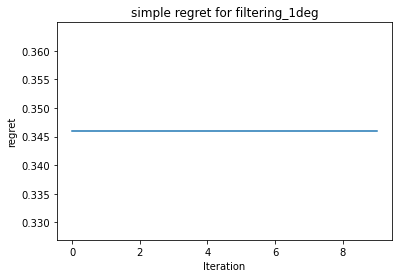

In [16]:
cli_args.beta=2.0 
cli_args.filter_interval=5
cli_args.opt_horizon=10
cli_args.train_times=1000 
cli_args.learning_rate=6 
lr_rank = -cli_args.learning_rate
learning_rate = 10 ** lr_rank

print(f"Learning rate {learning_rate} Filtering {cli_args.o} fix_seed {fix_seed} beta {cli_args.beta} Regularize {cli_args.r} Low dim {low_dim} CI intersection {cli_args.intersection} verbose={verbose}")
if cli_args.o:
    res2 = ol_filter_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output, n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim, beta=cli_args.beta, regularize=cli_args.r,   ci_intersection=cli_args.intersection,
                    n_iter=cli_args.opt_horizon, filter_interval=cli_args.filter_interval, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_times=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=not cli_args.return_model, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir)
else:
    pure_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output,  n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim,
                    n_iter=cli_args.opt_horizon, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_iter=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=True, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir,)


torch.Size([1000]) torch.Size([1000])


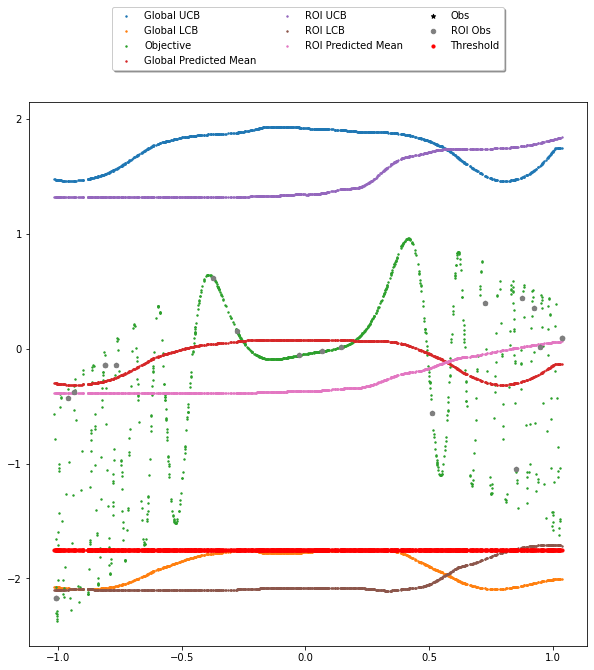

In [34]:
plot_result(res2)

# Exp3

Learning rate 0.0001 Filtering True fix_seed True beta 2.0 Regularize False Low dim True CI intersection False verbose=True


100%|██████████| 10/10 [00:00<00:00, 33.80it/s, loss=1.05]













100%|██████████| 10/10 [00:00<00:00, 35.75it/s, loss=1.11]













100%|██████████| 10/10 [00:00<00:00, 36.55it/s, loss=1.21]













100%|██████████| 10/10 [00:00<00:00, 38.60it/s, loss=1.18]













Experiment Rep: 100%|██████████| 1/1 [00:26<00:00, 26.07s/it]


File stored to ./res/intersec/visual/OL-filtering_1deg-2.0-none-ucb-R1-P2-T100_I30_L4-TI10-USexact


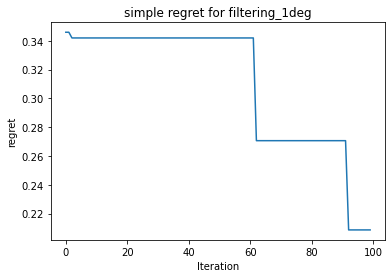

In [27]:
cli_args.beta=2.0 
cli_args.filter_interval=30
cli_args.opt_horizon=100
cli_args.train_times=10 
cli_args.learning_rate=4 
lr_rank = -cli_args.learning_rate
learning_rate = 10 ** lr_rank

print(f"Learning rate {learning_rate} Filtering {cli_args.o} fix_seed {fix_seed} beta {cli_args.beta} Regularize {cli_args.r} Low dim {low_dim} CI intersection {cli_args.intersection} verbose={verbose}")
if cli_args.o:
    res3 = ol_filter_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output, n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim, beta=cli_args.beta, regularize=cli_args.r,   ci_intersection=cli_args.intersection,
                    n_iter=cli_args.opt_horizon, filter_interval=cli_args.filter_interval, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_times=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=not cli_args.return_model, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir)
else:
    pure_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output,  n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim,
                    n_iter=cli_args.opt_horizon, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_iter=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=True, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir,)


torch.Size([1000]) torch.Size([1000])


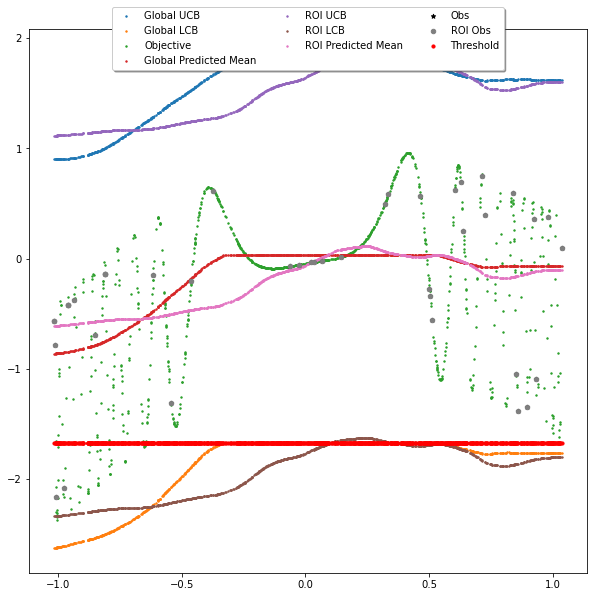

In [28]:
plot_result(res3)

# Exp4

Learning rate 0.0001 Filtering True fix_seed True beta 0.5 Regularize False Low dim True CI intersection False verbose=True


100%|██████████| 10/10 [00:00<00:00, 41.01it/s, loss=1.05]













100%|██████████| 10/10 [00:00<00:00, 37.12it/s, loss=1.11]













100%|██████████| 10/10 [00:00<00:00, 34.37it/s, loss=1.21]













100%|██████████| 10/10 [00:00<00:00, 39.18it/s, loss=1.18]













Experiment Rep: 100%|██████████| 1/1 [00:28<00:00, 28.35s/it]


File stored to ./res/intersec/visual/OL-filtering_1deg-0.5-none-ucb-R1-P2-T100_I30_L4-TI10-USexact


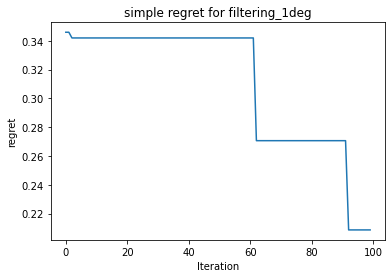

In [29]:
cli_args.beta=0.5
cli_args.filter_interval=30
cli_args.opt_horizon=100
cli_args.train_times=10 
cli_args.learning_rate=4 
lr_rank = -cli_args.learning_rate
learning_rate = 10 ** lr_rank

print(f"Learning rate {learning_rate} Filtering {cli_args.o} fix_seed {fix_seed} beta {cli_args.beta} Regularize {cli_args.r} Low dim {low_dim} CI intersection {cli_args.intersection} verbose={verbose}")
if cli_args.o:
    res4 = ol_filter_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output, n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim, beta=cli_args.beta, regularize=cli_args.r,   ci_intersection=cli_args.intersection,
                    n_iter=cli_args.opt_horizon, filter_interval=cli_args.filter_interval, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_times=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=not cli_args.return_model, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir)
else:
    pure_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output,  n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim,
                    n_iter=cli_args.opt_horizon, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_iter=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=True, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir,)


torch.Size([1000]) torch.Size([1000])


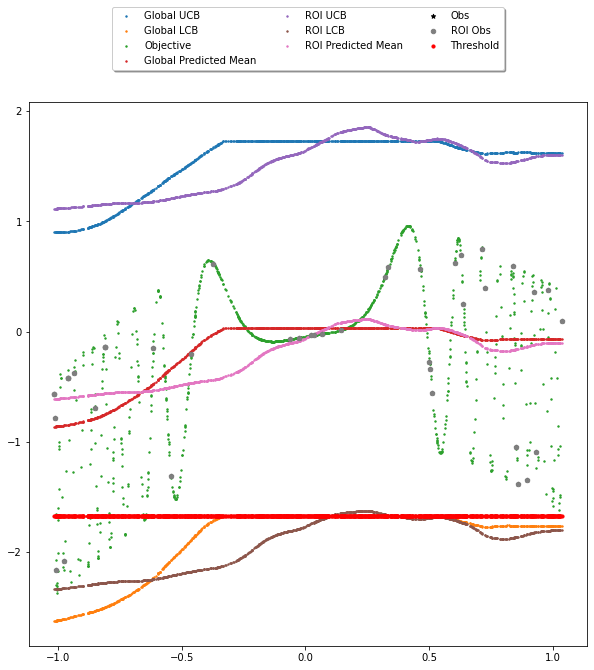

In [33]:
plot_result(res4)

# Exp5

Learning rate 0.0001 Filtering True fix_seed True beta 0.1 Regularize False Low dim True CI intersection False verbose=True


100%|██████████| 100/100 [00:03<00:00, 32.02it/s, loss=1.1]




























































































































100%|██████████| 100/100 [00:02<00:00, 35.37it/s, loss=1.05]




























































































































Experiment Rep: 100%|██████████| 1/1 [01:10<00:00, 70.32s/it]


File stored to ./res/intersec/visual/OL-filtering_1deg-0.1-none-ucb-R1-P2-T20_I10_L4-TI100-USexact


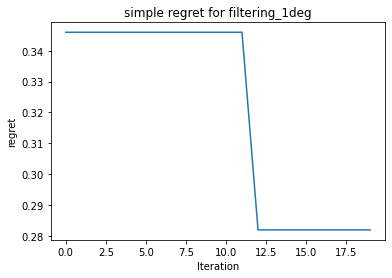

In [64]:
cli_args.beta=0.1
cli_args.filter_interval=10
cli_args.opt_horizon=20
cli_args.train_times=100
cli_args.learning_rate=4 
lr_rank = -cli_args.learning_rate
learning_rate = 10 ** lr_rank

print(f"Learning rate {learning_rate} Filtering {cli_args.o} fix_seed {fix_seed} beta {cli_args.beta} Regularize {cli_args.r} Low dim {low_dim} CI intersection {cli_args.intersection} verbose={verbose}")
if cli_args.o:
    res5 = ol_filter_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output, n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim, beta=cli_args.beta, regularize=cli_args.r,   ci_intersection=cli_args.intersection,
                    n_iter=cli_args.opt_horizon, filter_interval=cli_args.filter_interval, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_times=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=not cli_args.return_model, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir)
else:
    pure_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output,  n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim,
                    n_iter=cli_args.opt_horizon, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_iter=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=True, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir,)


torch.Size([1000]) torch.Size([1000])


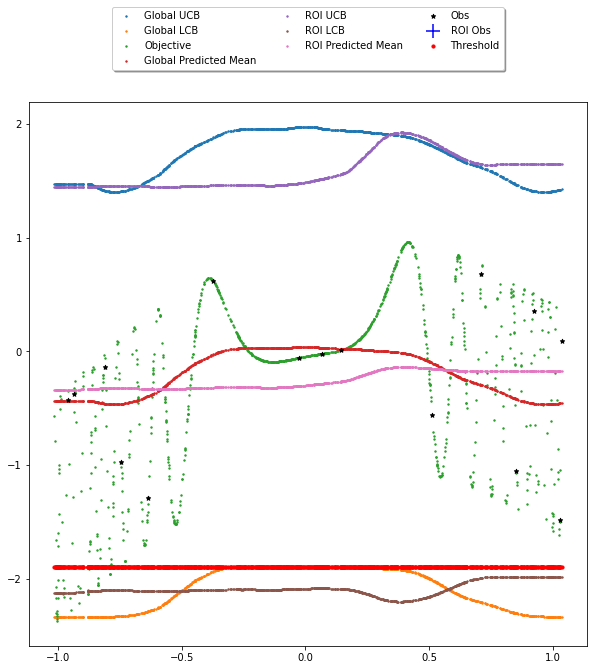

In [65]:
cli_args.beta=0.1
cli_args.filter_interval=10
cli_args.opt_horizon=20
cli_args.train_times=100
cli_args.learning_rate=4 
lr_rank = -cli_args.learning_rate
learning_rate = 10 ** lr_rank
plot_result(res5, 2)
path = f"1DEG-lr{learning_rate}-beta{cli_args.beta}-train{cli_args.train_times}"
dk, sim_dk_ae = res5
# torch.save(dk.model.state_dict(),f"{path}_dk.pt")
# torch.save(sim_dk_ae.dkl.model.state_dict(), f"{path}_sim_dk_ae.pt")


In [ ]:
# cli_args.beta=0.1
# cli_args.filter_interval=10
# cli_args.opt_horizon=20
# cli_args.train_times=100
# cli_args.learning_rate=4 
# lr_rank = -cli_args.learning_rate
# learning_rate = 10 ** lr_rank

# path = f"1DEG-lr{learning_rate}-beta{cli_args.beta}-train{cli_args.train_times}"
# dk, sim_dk_ae = 
# dk_state_dict = torch.load(f"{path}_dk.pt")
# sim_dk_ae_state_dict = torch.load(f"{path}_sim_dk_ae.pt")

torch.Size([1000]) torch.Size([1000])
Threshold -0.18415546417236328 -1.897552251815796
tensor([ 0.2465, -0.2015, -0.2438, -0.2142,  0.2531,  0.1198,  0.2613,  0.1949,
        -0.2429, -0.2142, -0.2382, -0.2456, -0.2404, -0.1733, -0.0734])


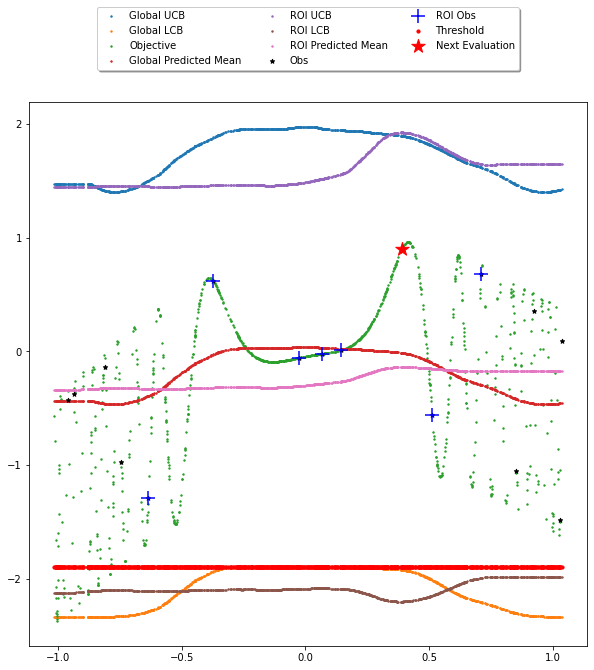

In [103]:
plot_result(res5, 0.23, 2)

torch.Size([1000]) torch.Size([1000])


/opt/homebrew/Caskroom/miniforge/base/envs/DS/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Threshold -0.18415546417236328 -0.18415546417236328
tensor([ 0.2465, -0.2015, -0.2438, -0.2142,  0.2531,  0.1198,  0.2613,  0.1949,
        -0.2429, -0.2142, -0.2382, -0.2456, -0.2404, -0.1733, -0.0734])


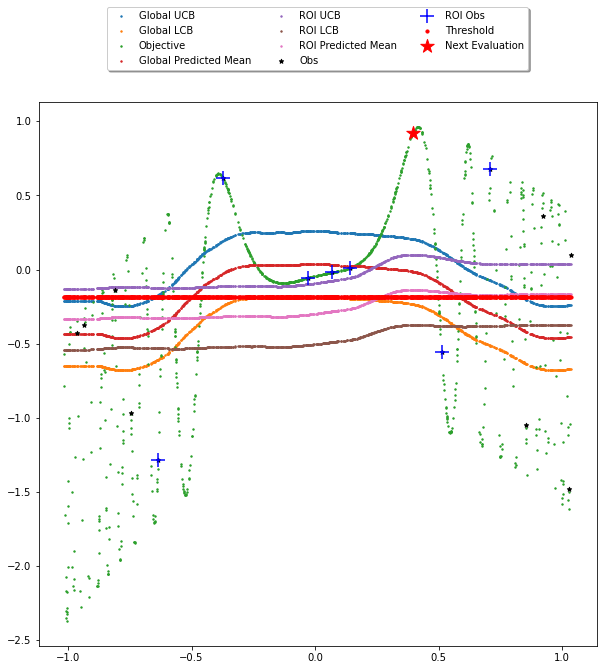

In [102]:
plot_result(res5, 0.23, 0.23)

# Exp6

Learning rate 0.0001 Filtering True fix_seed True beta 0.1 Regularize False Low dim True CI intersection False verbose=True


100%|██████████| 100/100 [00:10<00:00,  9.56it/s, loss=1.1]

































































































































































100%|██████████| 100/100 [00:11<00:00,  8.67it/s, loss=1.05]



























































































































































































100%|██████████| 100/100 [00:19<00:00,  5.17it/s, loss=1.18]

































































































































































Experiment Rep: 100%|██████████| 1/1 [09:37<00:00, 577.46s/it]


File stored to ./res/intersec/visual/OL-filtering_1deg-0.1-none-ucb-R1-P2-T30_I10_L4-TI100-USexact


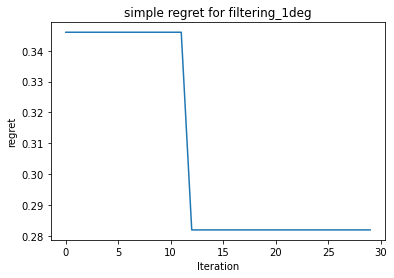

In [89]:
cli_args.beta=0.1
cli_args.filter_interval=10
cli_args.opt_horizon=30
cli_args.train_times=100
cli_args.learning_rate=4 
lr_rank = -cli_args.learning_rate
learning_rate = 10 ** lr_rank

print(f"Learning rate {learning_rate} Filtering {cli_args.o} fix_seed {fix_seed} beta {cli_args.beta} Regularize {cli_args.r} Low dim {low_dim} CI intersection {cli_args.intersection} verbose={verbose}")
if cli_args.o:
    res6 = ol_filter_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output, n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim, beta=cli_args.beta, regularize=cli_args.r,   ci_intersection=cli_args.intersection,
                    n_iter=cli_args.opt_horizon, filter_interval=cli_args.filter_interval, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_times=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=not cli_args.return_model, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir)
else:
    pure_dkbo(x_tensor=scaled_input_tensor, y_tensor=train_output,  n_init=cli_args.init_num, n_repeat=cli_args.run_times, low_dim=low_dim,
                    n_iter=cli_args.opt_horizon, acq=cli_args.acq_func, verbose=verbose, lr=learning_rate, name=cli_args.name, train_iter=cli_args.train_times,
                    plot_result=cli_args.p, save_result=cli_args.s, save_path=cli_args.subdir, return_result=True, fix_seed=fix_seed,  pretrained=pretrained, ae_loc=cli_args.aedir,)


torch.Size([1000]) torch.Size([1000])


/opt/homebrew/Caskroom/miniforge/base/envs/DS/lib/python3.9/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Threshold -0.2145695686340332 -1.9810850620269775
tensor([-0.0494, -0.1843, -0.1185, -0.1087, -0.0828, -0.0971, -0.1183, -0.1185,
        -0.1886, -0.1103, -0.1886, -0.1185, -0.1185, -0.1886, -0.1185, -0.1647])


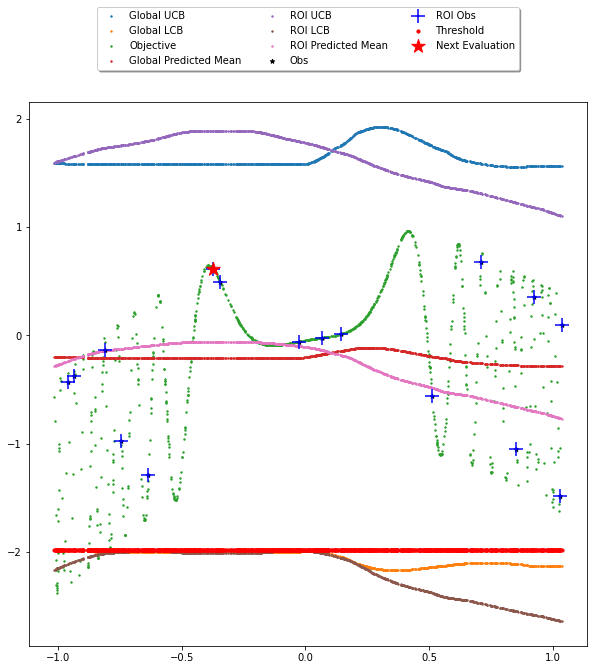

In [91]:
plot_result(res6, 0.1)